In [118]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
from scipy import signal

In [119]:
def display_images_side_by_side(image1, image2, title1='Image 1', title2='Image 2'):
    _, ax = plt.subplots(1, 2)

    ax[0].imshow(np.uint8(image1)), ax[0].axis('off'), ax[0].set_title(title1)
    ax[1].imshow(np.uint8(image2)), ax[1].axis('off'), ax[1].set_title(title2)

    plt.tight_layout()
    plt.show()


In [120]:
def add_gaussian_noise(img, disp):
    zg = np.random.normal(0, disp, np.shape(img))
    imgzg = np.clip(img + zg, a_min=0, a_max=255)
    return imgzg

def add_impulsive_noise(img, p0, p1):
    L, C, pl = np.shape(img)
    Nrpix0 = int(L * C * p0)
    Nrpix1 = int(L * C * p1)

    imgzg = img.copy()
    for plan_curent in range(pl):
        numere_intregiL = np.random.randint(0, L, Nrpix0)
        numere_intregiC = np.random.randint(0, C, Nrpix0)
        imgzg[numere_intregiL, numere_intregiC, plan_curent] = 0

        numere_intregiL = np.random.randint(0, L, Nrpix1)
        numere_intregiC = np.random.randint(0, C, Nrpix1)
        imgzg[numere_intregiL, numere_intregiC, plan_curent] = 255
    return imgzg

In [121]:
def psnr(img0, img):
    return peak_signal_noise_ratio(img0, img, data_range=255)

def ssim(img0, img):
    return structural_similarity(img0, img, channel_axis=-1, data_range=255)

In [122]:
def display_comparison(img, filtered_gaussian, filtered_impulsive):
    PSNR_gaussian = psnr(img, filtered_gaussian)
    PSNR_impulsive = psnr(img, filtered_impulsive)
    SSIM_gaussian = ssim(img, filtered_gaussian)
    SSIM_impulsive = ssim(img, filtered_impulsive)
    print(f"PSNR GAUSSIAN: {PSNR_gaussian:.2f}\tPSNR IMPULSIVE: {PSNR_impulsive:.2f}")
    print(f"SSIM GAUSSIAN: {SSIM_gaussian:.2f}\tSSIM IMPULSIVE: {SSIM_impulsive:.2f}")
    display_images_side_by_side(filtered_gaussian, filtered_impulsive, title1='Gaussian noise', title2='Impulsive noise')

In [123]:
def bordered(img, window_size):
    kernel = np.zeros((window_size, window_size))
    kernel[window_size//2, window_size//2] = 1
    return signal.convolve2d(img, kernel, mode='full', boundary = 'symm')

In [124]:
def mean_filter(img, window_size=3):
    if len(img.shape) == 2:
        return _apply_mean_filter(img, window_size)
    else:
        imgout = np.zeros_like(img)
        for channel in range(img.shape[2]):
            imgout[:, :, channel] = _apply_mean_filter(img[:, :, channel], window_size)
        return imgout

def _apply_mean_filter(img, window_size):
    [L, C] = np.shape(img)
    W = window_size // 2
    bordered_img = bordered(img, window_size)
    imgout = np.zeros_like(img)

    for l in range(L):
        for c in range(C):
            window = bordered_img[l:l+2*W+1, c:c+2*W+1]
            imgout[l, c] = np.mean(window)
    return imgout

In [125]:
def median_filter(img, window_size=3):
    if len(img.shape) == 2:
        return _apply_mean_filter(img, window_size)
    else:
        imgout = np.zeros_like(img)
        for channel in range(img.shape[2]):
            imgout[:, :, channel] = _apply_median_filter(img[:, :, channel], window_size)
        return imgout

def _apply_median_filter(img, window_size):
    [L, C] = np.shape(img)
    W = window_size // 2
    bordered_img = bordered(img, window_size)
    imgout = np.zeros_like(img)

    for l in range(L):
        for c in range(C):
            window = bordered_img[l:l+2*W+1, c:c+2*W+1]
            imgout[l, c] = np.median(window)
    return imgout

In [126]:
def alpha_tm_filter(img, window_size=3, d=2):
    if len(img.shape) == 2:
        return _apply_alpha_tm_filter(img, window_size, L)
    else:
        imgout = np.zeros_like(img)
        for channel in range(img.shape[2]):
            imgout[:, :, channel] = _apply_alpha_tm_filter(img[:, :, channel], window_size, d)
        return imgout

def _apply_alpha_tm_filter(img, window_size, d):
    [L, C] = np.shape(img)
    W = window_size // 2
    bordered_img = bordered(img, window_size)
    imgout = np.zeros_like(img)

    for l in range(L):
        for c in range(C):
            window = bordered_img[l:l+2*W+1, c:c+2*W+1]
            flattened = np.sort(window.flatten())
            sorted_window = np.sort(flattened)
            trimmed = sorted_window[d // 2: -d // 2]
            imgout[l, c] = np.mean(trimmed)
    return imgout


In [127]:
def mtm_filter(img, window_size=3, q=65):
    if len(img.shape) == 2:
        return _apply_mtm_filter(img, window_size, q)
    else:
        imgout = np.zeros_like(img)
        for channel in range(img.shape[2]):
            imgout[:, :, channel] = _apply_mtm_filter(img[:, :, channel], window_size, q)
        return imgout

def _apply_mtm_filter(img, window_size, q):
    [L, C] = np.shape(img)
    W = window_size // 2
    bordered_img = bordered(img, window_size)
    imgout = np.zeros_like(img)

    for l in range(L):
        for c in range(C):
            window = bordered_img[l:l+2*W+1, c:c+2*W+1]
            sorted_window = np.sort(window.flatten())
            I_m = np.median(sorted_window)
            trimmed = sorted_window[np.abs(sorted_window - I_m) <= q]
            imgout[l, c] = np.mean(trimmed)
    return imgout

In [128]:
def gtm_filter(img, window_size=3, q=65, center_weight=0.5):
    if len(img.shape) == 2:
        return _apply_gtm_filter(img, window_size, q, center_weight)
    else:
        imgout = np.zeros_like(img)
        for channel in range(img.shape[2]):
            imgout[:, :, channel] = _apply_gtm_filter(img[:, :, channel], window_size, q, center_weight)
        return imgout

def _apply_gtm_filter(img, window_size, q, center_weight):
    [L, C] = np.shape(img)
    W = window_size // 2
    bordered_img = bordered(img, window_size)
    imgout = np.zeros_like(img)

    for l in range(L):
        for c in range(C):
            window = bordered_img[l:l+2*W+1, c:c+2*W+1]
            sorted_window = np.sort(window.flatten())
            I_m = np.median(sorted_window)
            trimmed = sorted_window[np.abs(sorted_window - I_m) <= q]
            center_pixel = window[W, W]

            # Weighted averaging including center pixel
            weighted_sum = center_pixel * center_weight + np.sum(trimmed)
            total_weight = center_weight + len(trimmed)
            imgout[l, c] = weighted_sum / total_weight

    return imgout

In [129]:
Beta = 0
A = 2

def gvwtm_filter(img, window_size=3):
    if len(img.shape) == 2:
        return _apply_gvwtm_filter(img, window_size)
    else:
        imgout = np.zeros_like(img)
        for channel in range(img.shape[2]):
            imgout[:, :, channel] = _apply_gvwtm_filter(img[:, :, channel], window_size)
        return imgout

def w(x):
    epsilon = 1e-6
    return np.exp(-A * (x / (x - 1 + epsilon)) ** 2)

def _apply_gvwtm_filter(img, window_size):
    [L, C] = np.shape(img)
    W = window_size // 2
    bordered_img = bordered(img, window_size)
    imgout = np.zeros_like(img)

    for l in range(L):
        for c in range(C):
            window = bordered_img[l:l+2*W+1, c:c+2*W+1]
            sorted_window = np.sort(window.flatten())
            I_m = np.median(sorted_window)
            trimmed = sorted_window[np.abs(sorted_window - I_m) <= q]
            I = np.sort(np.ndarray.flatten(window))
            I_m = np.median(I)
            weights = w(np.abs(window - I_m) / 255.0)
            V_c = np.sum(weights * window) / np.sum(weights)
            imgout[l, c] = V_c
    return imgout


(256, 256, 3)


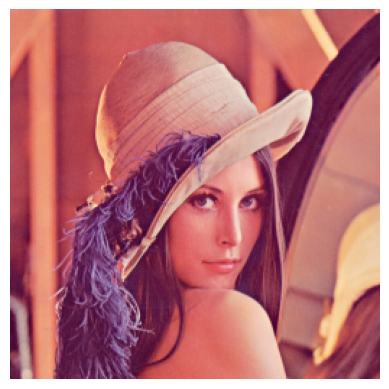

(<Figure size 640x480 with 1 Axes>,
 (np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5)),
 None)

In [130]:
img = io.imread('lenamic.png')
img = img[:, :, 0:3]
print(np.shape(img))
plt.figure(), plt.imshow(img), plt.axis('off'), plt.show()

PSNR GAUSSIAN: 14.83	PSNR IMPULSIVE: 12.61
SSIM GAUSSIAN: 0.19	SSIM IMPULSIVE: 0.14


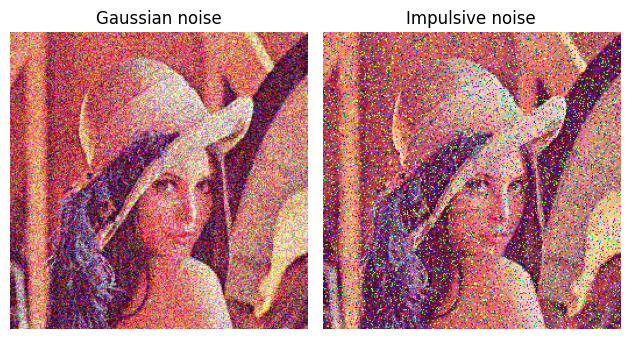

In [131]:
imgzg_gaussian = add_gaussian_noise(img, 50)
imgzg_impulsive = add_impulsive_noise(img, 0.1, 0.1)
display_comparison(img, imgzg_gaussian, imgzg_impulsive)

PSNR GAUSSIAN: 22.87	PSNR IMPULSIVE: 22.80
SSIM GAUSSIAN: 0.46	SSIM IMPULSIVE: 0.50


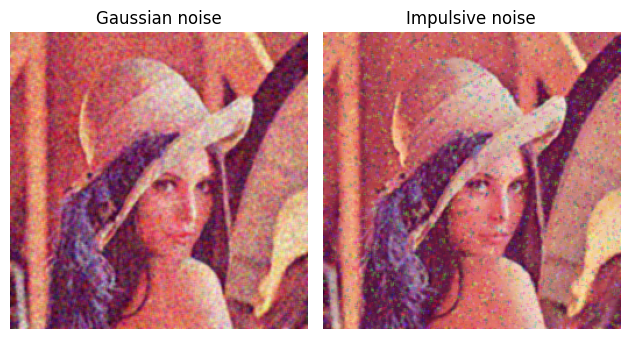

In [132]:
filtered_gaussian = alpha_tm_filter(imgzg_gaussian)
filtered_impulsive = alpha_tm_filter(imgzg_impulsive)
display_comparison(img, filtered_gaussian, filtered_impulsive)

PSNR GAUSSIAN: 20.82	PSNR IMPULSIVE: 28.07
SSIM GAUSSIAN: 0.38	SSIM IMPULSIVE: 0.85


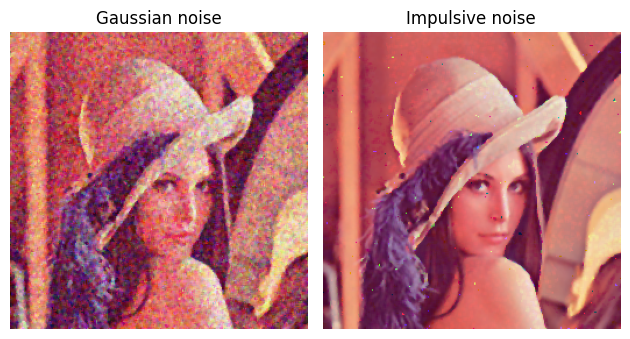

In [133]:
filtered_gaussian = mtm_filter(imgzg_gaussian)
filtered_impulsive = mtm_filter(imgzg_impulsive)
display_comparison(img, filtered_gaussian, filtered_impulsive)

PSNR GAUSSIAN: 21.05	PSNR IMPULSIVE: 27.73
SSIM GAUSSIAN: 0.39	SSIM IMPULSIVE: 0.79


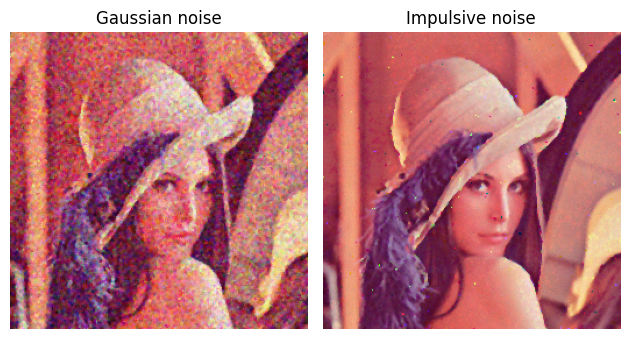

In [134]:
filtered_gaussian = gtm_filter(imgzg_gaussian)
filtered_impulsive = gtm_filter(imgzg_impulsive)
display_comparison(img, filtered_gaussian, filtered_impulsive)